In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scout.utils import read_csv
from scipy import stats

In [5]:
working_dir = '/data/datasets/organoid_phenotyping/analysis/zika_vs_mock/'

analysis = pd.read_csv(os.path.join(working_dir, 'analysis.csv'), index_col=0)

analysis['folder'] = analysis['type']

idx = np.where(['zika1' in p for p in analysis.index])[0]
analysis['type'].iloc[idx] = 'Zika_mock'
idx = np.where(['zika5' in p for p in analysis.index])[0]
analysis['type'].iloc[idx] = 'Zika_mock'
idx = np.where(['ctrl1' in p for p in analysis.index])[0]
analysis['type'].iloc[idx] = 'Zika'
idx = np.where(['ctrl5' in p for p in analysis.index])[0]
analysis['type'].iloc[idx] = 'Zika'

analysis.head()

,type,folder
path,,
20190625_14_48_13_AA_ef24-zika1_488LP15_561LP140_642LP50,Zika_mock,Zika
20190625_15_22_42_AA_ef24-zika2_488LP20_561LP140_642LP50,Zika,Zika
20190625_16_04_10_AA_ef24-zika3_488LP18_561LP140_642LP50,Zika,Zika
20190625_16_22_54_AA_ef24-zika4_488LP18_561LP140_642LP50,Zika,Zika
20190625_16_31_09_AA_ef24-zika5_488LP14_561LP140_642LP50,Zika_mock,Zika


In [6]:
data = {}
for foldername in analysis.index:
    if analysis.loc[foldername]['type'] == 'Zika':
        feats = pd.read_excel(os.path.join(working_dir, 
                                           analysis.loc[foldername]['folder'], 
                                           foldername, 
                                           'organoid_features.xlsx'), 
                              index_col=0, 
                              skiprows=1)
        data[foldername] = feats[foldername]
df = pd.DataFrame(data, index=feats.index)
df.head()

,20190625_15_22_42_AA_ef24-zika2_488LP20_561LP140_642LP50,20190625_16_04_10_AA_ef24-zika3_488LP18_561LP140_642LP50,20190625_16_22_54_AA_ef24-zika4_488LP18_561LP140_642LP50,20190625_17_15_27_AA_ef24-zika6_488LP25_561LP140_642LP50,20190625_12_18_15_AA_ef24-ctrl1_488LP14_561LP140_642LP50,20190625_14_13_45_AA_ef24-ctrl5_488LP13_561LP140_642LP50
dataset,,,,,,
"DN nbrhd, sox2 count",32.0,13.0,8.0,24.0,18.0,24.0
"DN nbrhd, tbr1 count",4.0,2.0,3.0,8.0,5.0,7.0
"DN nbrhd, dn count",160178.0,50588.0,96575.0,80091.0,122841.0,84802.0
"SOX2 nbrhd, sox2 count",165038.0,115704.0,99024.0,55425.0,215315.0,259107.0
"SOX2 nbrhd, tbr1 count",626.0,795.0,218.0,313.0,777.0,709.0


Show correlation heatmap

In [7]:
from itertools import product
from scipy.stats import pearsonr
from tqdm import tqdm_notebook as tqdm

In [8]:
features = list(df.index)
combinations = list(product(features, features))

len(combinations), len(features) ** 2

(70225, 70225)

In [9]:
df_imputed = df.fillna(method='backfill')

In [10]:
corr = []
R = np.zeros((len(features), len(features)))
P = np.zeros((len(features), len(features)))
for combination in tqdm(combinations, total=len(combinations)):
    feat1 = combination[0]
    feat2 = combination[1]
    i = features.index(feat1)
    j = features.index(feat2)
    a = df_imputed.loc[feat1]
    b = df_imputed.loc[feat2]
    # remove nans
    keep = np.logical_and(~np.isnan(a), ~np.isnan(b))
    a = a[keep]
    b = b[keep]
    r, p = pearsonr(a, b)
#     if np.isclose(r, 1.0):
#         print(feat1 == feat2)
    corr.append(r)
    R[i, j] = r
    P[i, j] = p
corr = np.asarray(corr)

In [11]:
df_r = pd.DataFrame(R, index=features, columns=features)
df_r.head()

,"DN nbrhd, sox2 count","DN nbrhd, tbr1 count","DN nbrhd, dn count","SOX2 nbrhd, sox2 count","SOX2 nbrhd, tbr1 count","SOX2 nbrhd, dn count","TBR1 nbrhd, sox2 count","TBR1 nbrhd, tbr1 count","TBR1 nbrhd, dn count","DP nbrhd, sox2 count",...,"MidSOX2 nbrhd, tbr1 surface distance mean (um)","MidSOX2 nbrhd, tbr1 surface distance stdev (um)","MidSOX2 nbrhd, dn surface distance mean (um)","MidSOX2 nbrhd, dn surface distance stdev (um)","MidInter nbrhd, sox2 surface distance mean (um)","MidInter nbrhd, sox2 surface distance stdev (um)","MidInter nbrhd, tbr1 surface distance mean (um)","MidInter nbrhd, tbr1 surface distance stdev (um)","MidInter nbrhd, dn surface distance mean (um)","MidInter nbrhd, dn surface distance stdev (um)"
"DN nbrhd, sox2 count",1.000000,0.528218,0.562087,0.291857,0.228316,0.976579,-0.077343,0.471546,0.732364,0.153117,...,0.757903,0.698640,-0.040889,-0.073288,-0.501301,-0.513451,-0.170019,-0.363147,-0.444071,-0.458913
"DN nbrhd, tbr1 count",0.528218,1.000000,0.009006,0.142468,-0.180473,0.465812,-0.192561,0.186858,-0.111574,0.066973,...,0.392582,-0.118665,-0.640465,-0.732407,-0.681400,-0.737027,-0.561093,-0.817203,-0.638103,-0.754537
"DN nbrhd, dn count",0.562087,0.009006,1.000000,0.310364,0.025640,0.673193,-0.053044,0.557256,0.814195,0.352721,...,0.387898,0.516512,0.132164,0.150656,-0.161650,0.151202,-0.066946,0.283456,-0.413508,-0.200240
"SOX2 nbrhd, sox2 count",0.291857,0.142468,0.310364,1.000000,0.678748,0.186963,0.603065,0.794375,0.468492,0.705450,...,-0.363182,-0.009059,0.483266,0.425178,0.361911,0.411637,0.647811,0.401799,0.366283,0.382619
"SOX2 nbrhd, tbr1 count",0.228316,-0.180473,0.025640,0.678748,1.000000,0.071389,0.894458,0.716457,0.468134,0.713918,...,-0.134580,0.410161,0.474694,0.515290,0.244531,0.241048,0.714691,0.373025,0.553012,0.468365


In [12]:
for i, f in enumerate(features):
    print(i, f)

0 DN nbrhd, sox2 count
1 DN nbrhd, tbr1 count
2 DN nbrhd, dn count
3 SOX2 nbrhd, sox2 count
4 SOX2 nbrhd, tbr1 count
5 SOX2 nbrhd, dn count
6 TBR1 nbrhd, sox2 count
7 TBR1 nbrhd, tbr1 count
8 TBR1 nbrhd, dn count
9 DP nbrhd, sox2 count
10 DP nbrhd, tbr1 count
11 DP nbrhd, dn count
12 MidTBR1 nbrhd, sox2 count
13 MidTBR1 nbrhd, tbr1 count
14 MidTBR1 nbrhd, dn count
15 MidSOX2 nbrhd, sox2 count
16 MidSOX2 nbrhd, tbr1 count
17 MidSOX2 nbrhd, dn count
18 MidInter nbrhd, sox2 count
19 MidInter nbrhd, tbr1 count
20 MidInter nbrhd, dn count
21 DN nbrhd fraction
22 SOX2 nbrhd fraction
23 TBR1 nbrhd fraction
24 DP nbrhd fraction
25 MidTBR1 nbrhd fraction
26 MidSOX2 nbrhd fraction
27 MidInter nbrhd fraction
28 TBR1 / SOX2 ratio
29 MidTBR1 / MidSOX2 ratio
30 MidInter / DN ratio
31 DN nbrhd, eq diam mean
32 DN nbrhd, eq diam stdev
33 SOX2 nbrhd, eq diam mean
34 SOX2 nbrhd, eq diam stdev
35 TBR1 nbrhd, eq diam mean
36 TBR1 nbrhd, eq diam stdev
37 DP nbrhd, eq diam mean
38 DP nbrhd, eq diam stdev
39

In [14]:
scales = np.asarray(157 * ['cell'] + (206-157) * ['cyto'] + (265 - 206) * ['organoid'])
scales = pd.Series(scales, index=df_r.index)
len(scales)

265

In [15]:
lut = dict(zip(scales.unique(), "rgb"))
lut

{'cell': 'r', 'cyto': 'g', 'organoid': 'b'}

In [16]:
row_colors = scales.map(lut)

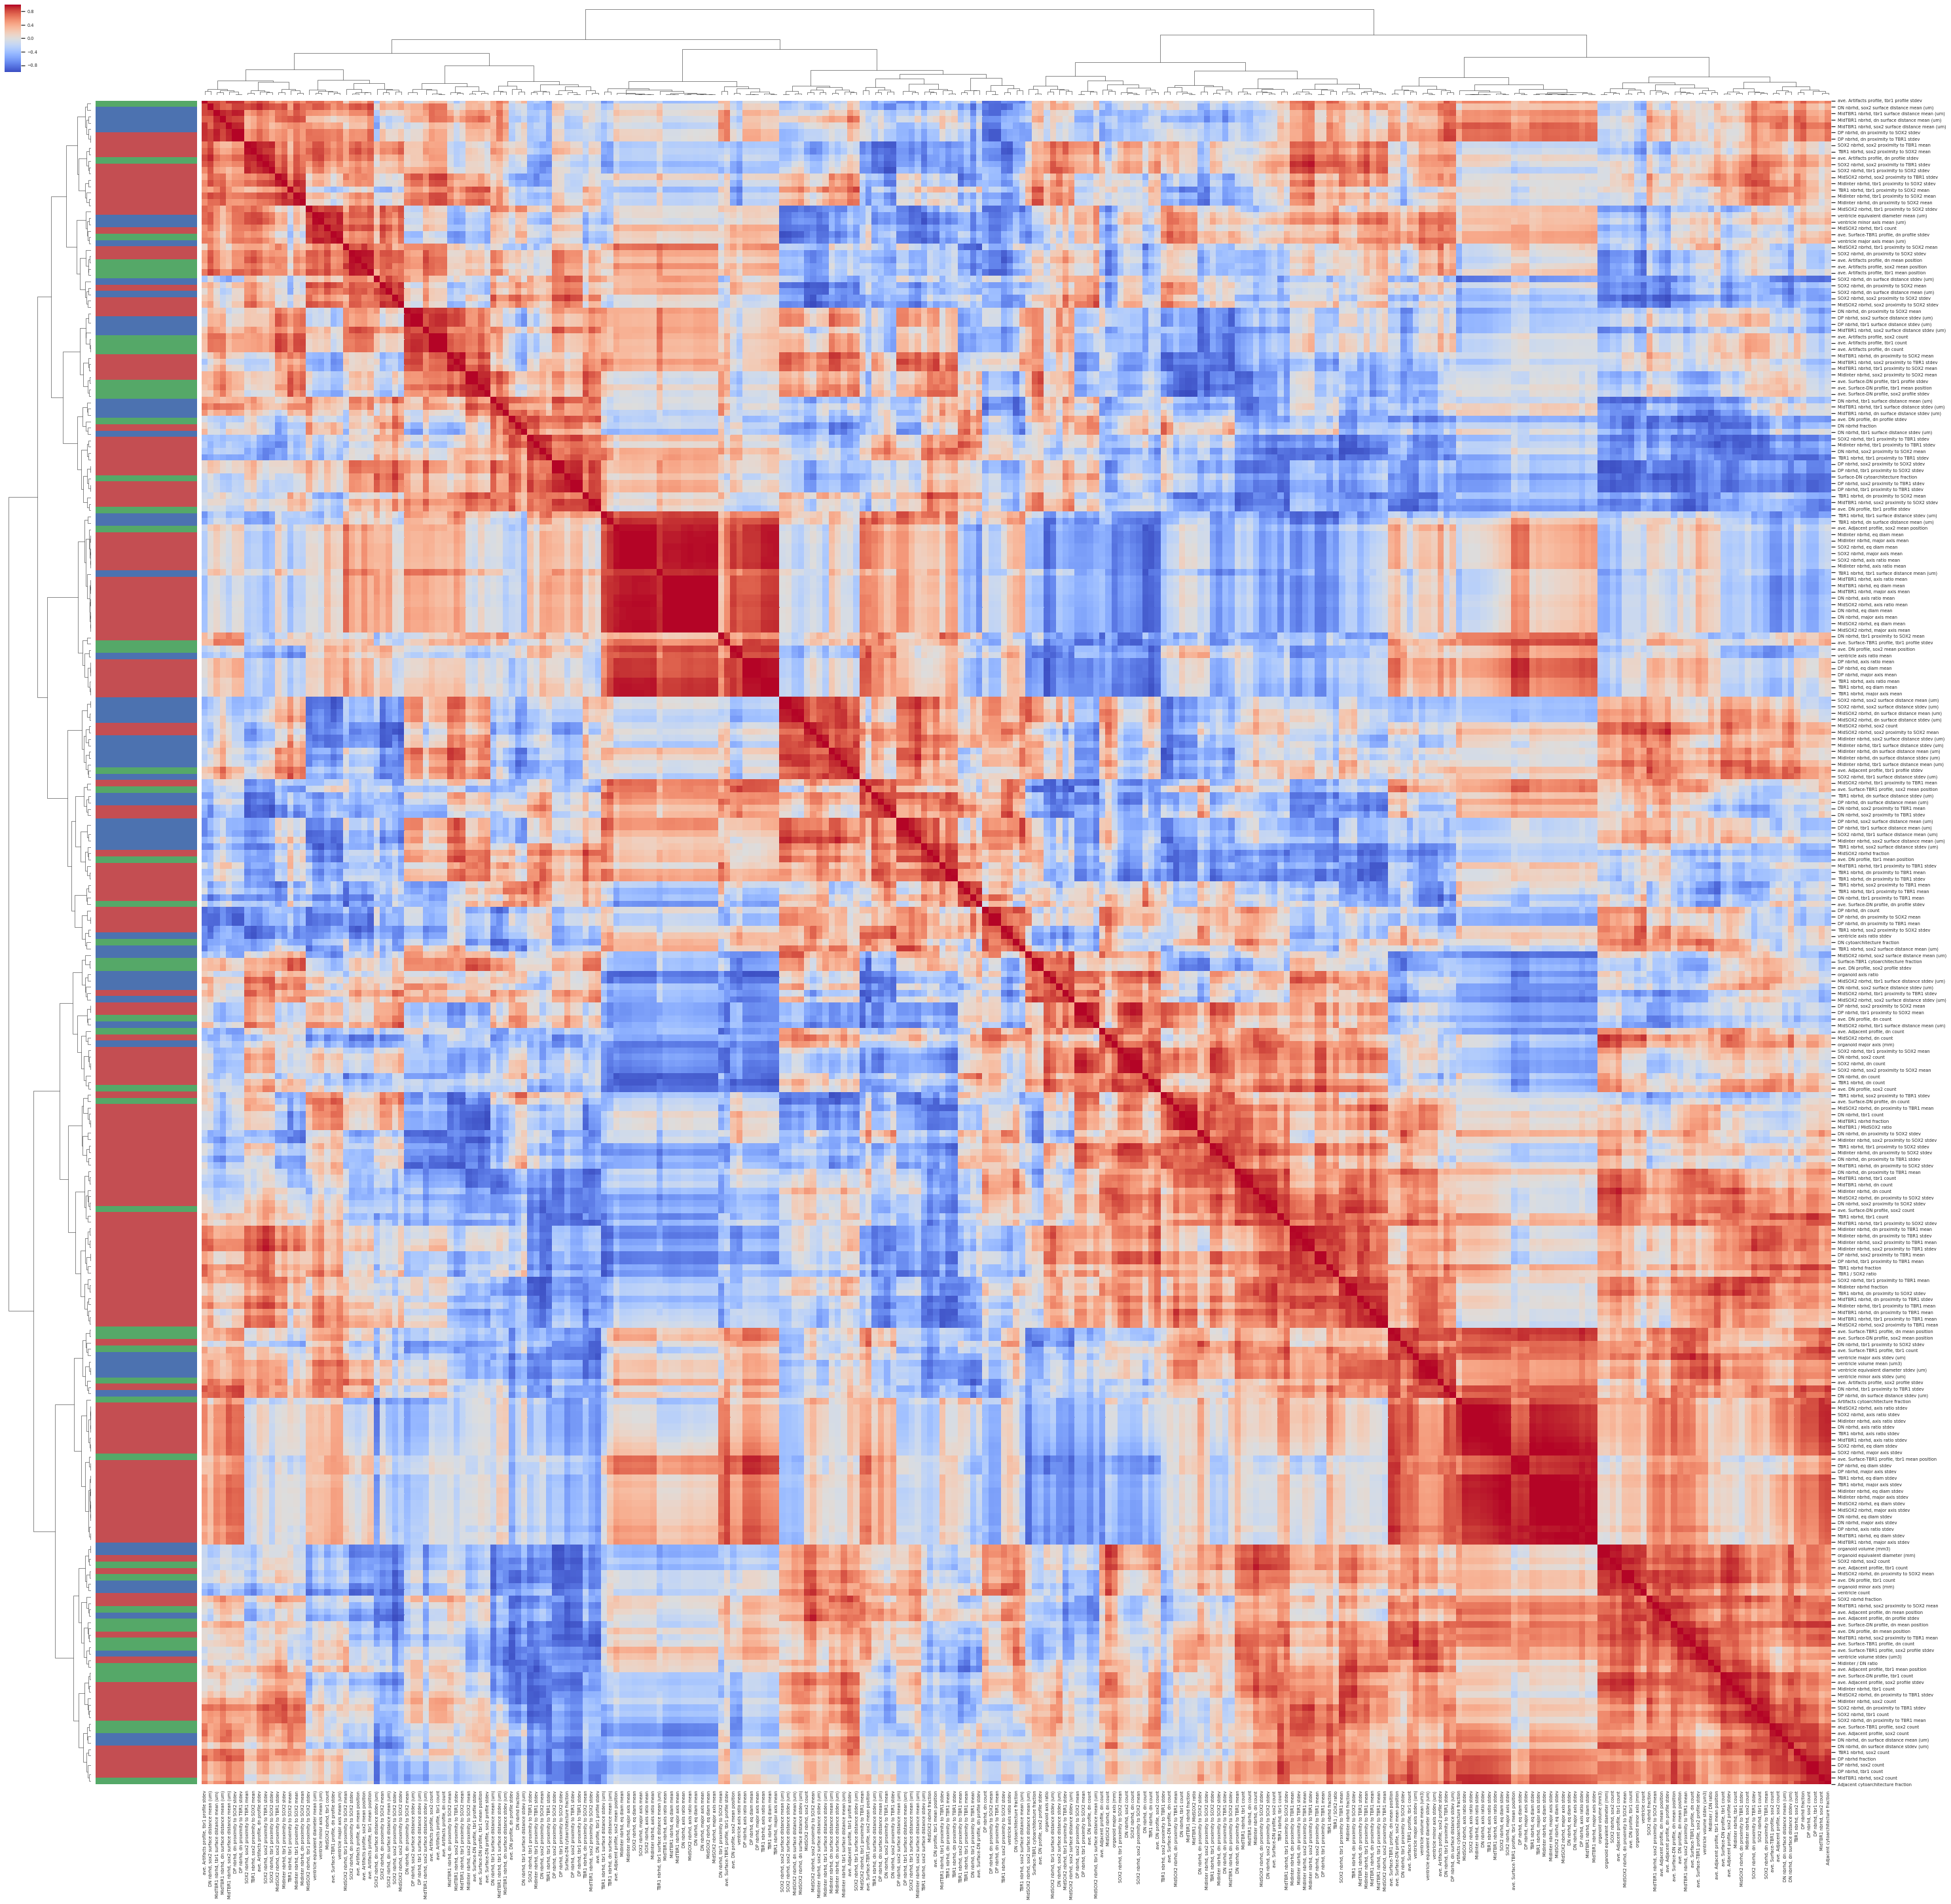

In [17]:
sns.set(font_scale=0.6)
cg = sns.clustermap(df_r, 
                    method='ward', 
                    metric='euclidean',
                    cmap='coolwarm', 
                    row_colors=row_colors,
                    figsize=(50, 50), 
                    vmin=-1, 
                    vmax=1)
# plt.savefig(os.path.join(working_dir, 'clustermap.pdf'), bbox_inches='tight')
plt.show()

In [21]:
# Save table
cluster_idx = cg.dendrogram_col.reordered_ind
sorted_features = np.asarray(features)[cluster_idx]
df_clustered = df_r.reindex(sorted_features)[sorted_features]
# df_clustered.to_excel(os.path.join(working_dir, 'clustered_correlation_table.xlsx'))

Construct graph from correlations

In [22]:
from pyvis import network as net
import networkx as nx

In [23]:
# Drop artifacts and double positive features
features_sorted = np.asarray(features)[cluster_idx]
keep = np.asarray([i for i, f in enumerate(features_sorted) if not 'DP' in f and not 'Artifact' in f])

len(keep), len(features_sorted)

(227, 265)

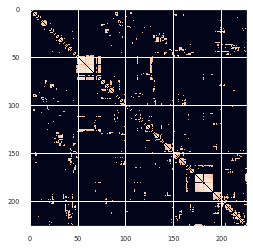

In [45]:
rmin = 0.85

R_sorted = R[cluster_idx][:, cluster_idx]
R_eye = R_sorted[keep][:, keep]
R_eye = np.abs(R_eye) - np.eye(len(R_eye))
mask = (R_eye > rmin)
R_eye = R_eye * mask

plt.imshow(R_eye, clim=[0, 1])
plt.show()

In [46]:
n_edges = (R_eye > 0).sum(axis=0)

max_edges = n_edges.max()
max_idx = np.where(n_edges == max_edges)[0]

edges_sort = np.argsort(n_edges)[::-1]

features_sorted_edges = np.asarray(features_sorted)[keep][edges_sort]

feature_edges = pd.DataFrame({'feature': features_sorted_edges, 'rank': n_edges[edges_sort]})

# feature_edges.to_excel(os.path.join(working_dir, 'feature_edge_rank_0_75.xlsx'))

feature_edges.head(10)

,feature,rank
0,"MidInter nbrhd, major axis mean",25
1,"TBR1 nbrhd, dn surface distance mean (um)",25
2,"TBR1 nbrhd, major axis mean",25
3,"TBR1 nbrhd, eq diam mean",25
4,"SOX2 nbrhd, major axis mean",25
5,"SOX2 nbrhd, eq diam mean",25
6,"MidInter nbrhd, eq diam mean",25
7,"MidSOX2 nbrhd, eq diam mean",24
8,"MidInter nbrhd, axis ratio mean",24
9,"SOX2 nbrhd, axis ratio mean",24


In [47]:
rename = dict(zip(np.arange(len(R_eye)).astype(str), np.asarray(features_sorted)[keep]))
colors = {'cell': 'Red', 
          'cyto': 'Green', 
          'organoid': 'Blue'}
colors_map = dict(zip(df_imputed.index, [colors[s] for s in scales]))

In [48]:
nxg = nx.from_numpy_matrix(R_eye)

g = net.Network(notebook=True, height='1000px', width='1000px')
g.from_nx(nxg)
for i, node in enumerate(g.nodes):
    feat = rename[g.nodes[i]['title']]
    g.nodes[i]['label'] = feat
    g.nodes[i]['color'] = colors_map[feat]
    
# len(g.nodes)
g.barnes_hut()
# g.repulsion()
# g.show(os.path.join(working_dir, 'feature_correlation_graph_0_85_nolabels.html'))
g.show('example.html')

## Linear regression analysis

Select cyto and cell level features for these analyses

In [277]:
df_imputed['scales'] = scales
df_imputed.head()

,20190419_14_35_07_AA_org1_488LP13_561LP120_642LP60,20190419_15_50_16_AA_org2_488LP13_561LP120_642LP60,20190419_16_09_03_AA_org3_488LP13_561LP120_642LP60,20190430_11_36_09_AA-4.30.19-org1_488LP12p5_561LP120_642LP50,20190430_15_06_10_AA-4.30.19-org3_488LP13_561LP120_642LP50,20190614_14_03_07_AA_ef23-1_488LP14_561LP120_642LP60,20190614_14_48_43_AA_ef23-2_488LP14_561LP120_642LP50,20190614_15_40_09_AA_ef23-3_488LP14_561LP120_642LP50,20190614_17_14_47_AA_ef23-4_488LP14_561LP120_642LP50,20190614_17_55_05_AA_ef23-5_488LP15_561LP120_642LP50,20190614_18_12_44_AA_ef23-6_488LP14_561LP120_642LP50,20190614_18_27_34_AA_ef23-7_488LP14_561LP120_642LP50,scales
input,,,,,,,,,,,,,
"DN nbrhd, sox2 count",174.0,30.0,162.0,189.0,345.0,121.0,207.0,162.0,145.0,103.0,1704.0,165.0,cell
"DN nbrhd, tbr1 count",110.0,37.0,50.0,21.0,105.0,63.0,171.0,143.0,106.0,31.0,538.0,68.0,cell
"DN nbrhd, dn count",257563.0,112764.0,135904.0,83305.0,296077.0,95223.0,471900.0,556212.0,341938.0,92981.0,79213.0,76304.0,cell
"SOX2 nbrhd, sox2 count",550868.0,362686.0,471401.0,494048.0,833321.0,218660.0,634230.0,707343.0,462029.0,134363.0,350636.0,85757.0,cell
"SOX2 nbrhd, tbr1 count",1296.0,435.0,1003.0,672.0,2094.0,838.0,2572.0,1652.0,1256.0,498.0,1715.0,686.0,cell


In [322]:
features

['DN nbrhd, sox2 count',
 'DN nbrhd, tbr1 count',
 'DN nbrhd, dn count',
 'SOX2 nbrhd, sox2 count',
 'SOX2 nbrhd, tbr1 count',
 'SOX2 nbrhd, dn count',
 'TBR1 nbrhd, sox2 count',
 'TBR1 nbrhd, tbr1 count',
 'TBR1 nbrhd, dn count',
 'DP nbrhd, sox2 count',
 'DP nbrhd, tbr1 count',
 'DP nbrhd, dn count',
 'MidTBR1 nbrhd, sox2 count',
 'MidTBR1 nbrhd, tbr1 count',
 'MidTBR1 nbrhd, dn count',
 'MidSOX2 nbrhd, sox2 count',
 'MidSOX2 nbrhd, tbr1 count',
 'MidSOX2 nbrhd, dn count',
 'MidInter nbrhd, sox2 count',
 'MidInter nbrhd, tbr1 count',
 'MidInter nbrhd, dn count',
 'DN nbrhd fraction',
 'SOX2 nbrhd fraction',
 'TBR1 nbrhd fraction',
 'DP nbrhd fraction',
 'MidTBR1 nbrhd fraction',
 'MidSOX2 nbrhd fraction',
 'MidInter nbrhd fraction',
 'TBR1 / SOX2 ratio',
 'MidTBR1 / MidSOX2 ratio',
 'MidInter / DN ratio',
 'DN nbrhd, eq diam mean',
 'DN nbrhd, eq diam stdev',
 'SOX2 nbrhd, eq diam mean',
 'SOX2 nbrhd, eq diam stdev',
 'TBR1 nbrhd, eq diam mean',
 'TBR1 nbrhd, eq diam stdev',
 'DP nbr

Organoid volume linear regression

In [324]:
import statsmodels.api as sm

organoid volume


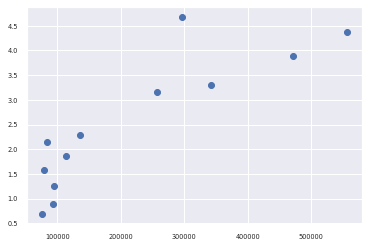

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                              1536.
Date:                Wed, 30 Oct 2019   Prob (F-statistic):                    2.75e-09
Time:                        10:45:13   Log-Likelihood:                          14.551
No. Observations:                  12   AIC:                                     -17.10
Df Residuals:                       6   BIC:                                     -14.19
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
DN nbrhd, dn count        3.606e-06   1.02e-06      3.520      0.013     1.1e-06    6.11e-06
SOX2 nbrhd, sox2 count    1.407e-06    8.4e-07      1.676      0.145   -6.48e-07    3.46e-06
TBR1 nbrhd, tbr1 count    2.131e-06   2.71e-06      0.787      0.461   -4.49e-06    8.75e-06
MidTBR1 nbrhd, dn count  -2.899e-06   1.69e-06     -1.715      0.137   -7.04e-06    1.24e-06
MidSOX2 nbrhd, dn count  -9.268e-07   1.76e-06     -0.526      0.618   -5.24e-06    3.38e-06
MidInter nbrhd, dn count  1.146e-05   5.46e-06      2.100      0.081    -1.9e-06    2.48e-05
==============================================================================
Omnibus:                        0.657   Durbin-Watson:                   1.042
Prob(Omnibus):                  0.720   Jarque-Bera (JB):                0.626
Skew:                          -0.418   Prob(JB):                        0.731
Kurtosis:                       2.257   Cond. No.                         137.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

ventricle volume


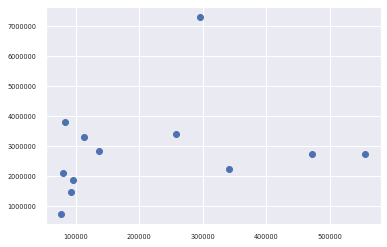

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.995
Model:                            OLS   Adj. R-squared (uncentered):              0.990
Method:                 Least Squares   F-statistic:                              197.1
Date:                Wed, 30 Oct 2019   Prob (F-statistic):                    1.28e-06
Time:                        10:45:13   Log-Likelihood:                         -165.33
No. Observations:                  12   AIC:                                      342.7
Df Residuals:                       6   BIC:                                      345.6
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
DN nbrhd, dn count           4.9216      3.316      1.484      0.188      -3.192      13.035
SOX2 nbrhd, sox2 count       0.2789      2.719      0.103      0.922      -6.373       6.931
TBR1 nbrhd, tbr1 count      42.9083      8.762      4.897      0.003      21.467      64.349
MidTBR1 nbrhd, dn count     13.2602      5.473      2.423      0.052      -0.132      26.652
MidSOX2 nbrhd, dn count    -12.8317      5.699     -2.251      0.065     -26.778       1.114
MidInter nbrhd, dn count   -42.1201     17.674     -2.383      0.055     -85.367       1.127
==============================================================================
Omnibus:                        7.698   Durbin-Watson:                   1.435
Prob(Omnibus):                  0.021   Jarque-Bera (JB):                3.486
Skew:                           1.084   Prob(JB):                        0.175
Kurtosis:                       4.506   Cond. No.                         137.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

ventricle count


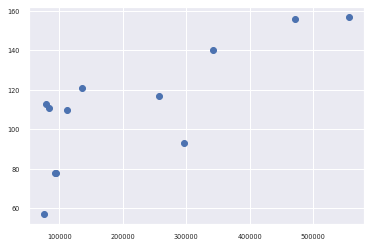

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.978
Model:                            OLS   Adj. R-squared (uncentered):              0.956
Method:                 Least Squares   F-statistic:                              44.74
Date:                Wed, 30 Oct 2019   Prob (F-statistic):                    0.000101
Time:                        10:45:14   Log-Likelihood:                         -51.009
No. Observations:                  12   AIC:                                      114.0
Df Residuals:                       6   BIC:                                      116.9
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
DN nbrhd, dn count          -0.0002      0.000     -0.695      0.513      -0.001       0.000
SOX2 nbrhd, sox2 count      -0.0002      0.000     -0.955      0.377      -0.001       0.000
TBR1 nbrhd, tbr1 count      -0.0005      0.001     -0.789      0.460      -0.002       0.001
MidTBR1 nbrhd, dn count   3.233e-05      0.000      0.081      0.938      -0.001       0.001
MidSOX2 nbrhd, dn count      0.0007      0.000      1.748      0.131      -0.000       0.002
MidInter nbrhd, dn count     0.0014      0.001      1.103      0.312      -0.002       0.005
==============================================================================
Omnibus:                        5.783   Durbin-Watson:                   1.296
Prob(Omnibus):                  0.055   Jarque-Bera (JB):                2.725
Skew:                           1.133   Prob(JB):                        0.256
Kurtosis:                       3.563   Cond. No.                         137.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [378]:
# Based on counts

keep = [
 'DN nbrhd, dn count',
 'SOX2 nbrhd, sox2 count',
 'TBR1 nbrhd, tbr1 count',
 'MidTBR1 nbrhd, dn count',
 'MidSOX2 nbrhd, dn count',
 'MidInter nbrhd, dn count'
]

df_filt = df_imputed.loc[keep]
X = df_filt.drop(columns='scales').T

print('organoid volume')
y = df_imputed.loc['organoid volume (mm3)'].drop('scales').astype(np.float64)[:, np.newaxis]

plt.figure()
plt.scatter(X.values[:, 0], y.ravel())
plt.show()

model = sm.OLS(y, X).fit()
display(model.summary())

print('ventricle volume')
y = df_imputed.loc['ventricle volume mean (um3)'].drop('scales').astype(np.float64)[:, np.newaxis]

plt.figure()
plt.scatter(X.values[:, 0], y.ravel())
plt.show()

model = sm.OLS(y, X).fit()
display(model.summary())

print('ventricle count')
y = df_imputed.loc['ventricle count'].drop('scales').astype(np.float64)[:, np.newaxis]

plt.figure()
plt.scatter(X.values[:, 0], y.ravel())
plt.show()

model = sm.OLS(y, X).fit()
display(model.summary())

organoid volume


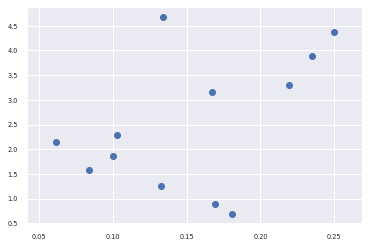

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.985
Model:                            OLS   Adj. R-squared (uncentered):              0.969
Method:                 Least Squares   F-statistic:                              63.99
Date:                Wed, 30 Oct 2019   Prob (F-statistic):                    3.56e-05
Time:                        10:46:02   Log-Likelihood:                         -4.4286
No. Observations:                  12   AIC:                                      20.86
Df Residuals:                       6   BIC:                                      23.77
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
DN nbrhd fraction          13.4265      3.685      3.644      0.011       4.411      22.442
SOX2 nbrhd fraction        12.3133      3.985      3.090      0.021       2.564      22.063
TBR1 nbrhd fraction        21.2012     14.649      1.447      0.198     -14.644      57.046
MidTBR1 nbrhd fraction     -8.1551      4.659     -1.751      0.131     -19.554       3.244
MidSOX2 nbrhd fraction    -13.3425      8.604     -1.551      0.172     -34.396       7.711
MidInter nbrhd fraction   -25.1179     15.793     -1.590      0.163     -63.761      13.525
==============================================================================
Omnibus:                        1.163   Durbin-Watson:                   1.334
Prob(Omnibus):                  0.559   Jarque-Bera (JB):                0.850
Skew:                          -0.581   Prob(JB):                        0.654
Kurtosis:                       2.406   Cond. No.                         61.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

ventricle volume


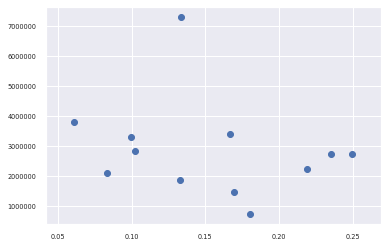

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.973
Model:                            OLS   Adj. R-squared (uncentered):              0.945
Method:                 Least Squares   F-statistic:                              35.45
Date:                Wed, 30 Oct 2019   Prob (F-statistic):                    0.000198
Time:                        10:46:02   Log-Likelihood:                         -175.49
No. Observations:                  12   AIC:                                      363.0
Df Residuals:                       6   BIC:                                      365.9
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
DN nbrhd fraction        8.402e+06   5.72e+06      1.470      0.192   -5.59e+06    2.24e+07
SOX2 nbrhd fraction      1.117e+07   6.18e+06      1.807      0.121   -3.96e+06    2.63e+07
TBR1 nbrhd fraction      7.431e+07   2.27e+07      3.269      0.017    1.87e+07     1.3e+08
MidTBR1 nbrhd fraction  -2.614e+06   7.23e+06     -0.362      0.730   -2.03e+07    1.51e+07
MidSOX2 nbrhd fraction  -2.824e+07   1.33e+07     -2.116      0.079   -6.09e+07    4.42e+06
MidInter nbrhd fraction  -5.89e+07   2.45e+07     -2.404      0.053   -1.19e+08    1.06e+06
==============================================================================
Omnibus:                        0.399   Durbin-Watson:                   1.106
Prob(Omnibus):                  0.819   Jarque-Bera (JB):                0.441
Skew:                          -0.334   Prob(JB):                        0.802
Kurtosis:                       2.339   Cond. No.                         61.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

ventricle count


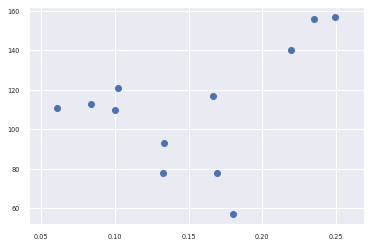

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.989
Model:                            OLS   Adj. R-squared (uncentered):              0.979
Method:                 Least Squares   F-statistic:                              93.08
Date:                Wed, 30 Oct 2019   Prob (F-statistic):                    1.18e-05
Time:                        10:46:03   Log-Likelihood:                         -46.681
No. Observations:                  12   AIC:                                      105.4
Df Residuals:                       6   BIC:                                      108.3
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
DN nbrhd fraction          97.7209    124.610      0.784      0.463    -207.189     402.631
SOX2 nbrhd fraction       371.4759    134.757      2.757      0.033      41.739     701.213
TBR1 nbrhd fraction      -451.0126    495.427     -0.910      0.398   -1663.278     761.253
MidTBR1 nbrhd fraction      0.6255    157.557      0.004      0.997    -384.902     386.153
MidSOX2 nbrhd fraction    455.2760    290.988      1.565      0.169    -256.745    1167.297
MidInter nbrhd fraction  -203.6534    534.102     -0.381      0.716   -1510.555    1103.248
==============================================================================
Omnibus:                       11.229   Durbin-Watson:                   1.521
Prob(Omnibus):                  0.004   Jarque-Bera (JB):                6.110
Skew:                          -1.439   Prob(JB):                       0.0471
Kurtosis:                       4.985   Cond. No.                         61.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [379]:
keep = [
 'DN nbrhd fraction',
 'SOX2 nbrhd fraction',
 'TBR1 nbrhd fraction',
 'MidTBR1 nbrhd fraction',
 'MidSOX2 nbrhd fraction',
 'MidInter nbrhd fraction'
]

df_filt = df_imputed.loc[keep]
X = df_filt.drop(columns='scales').T

print('organoid volume')
y = df_imputed.loc['organoid volume (mm3)'].drop('scales').astype(np.float64)[:, np.newaxis]

plt.figure()
plt.scatter(X.values[:, 0], y.ravel())
plt.show()

model = sm.OLS(y, X).fit()
display(model.summary())

print('ventricle volume')
y = df_imputed.loc['ventricle volume mean (um3)'].drop('scales').astype(np.float64)[:, np.newaxis]

plt.figure()
plt.scatter(X.values[:, 0], y.ravel())
plt.show()

model = sm.OLS(y, X).fit()
display(model.summary())

print('ventricle count')
y = df_imputed.loc['ventricle count'].drop('scales').astype(np.float64)[:, np.newaxis]

plt.figure()
plt.scatter(X.values[:, 0], y.ravel())
plt.show()

model = sm.OLS(y, X).fit()
display(model.summary())

organoid volume


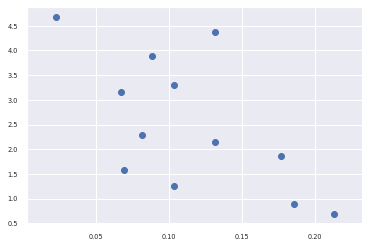

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.978
Model:                            OLS   Adj. R-squared (uncentered):              0.963
Method:                 Least Squares   F-statistic:                              62.85
Date:                Wed, 30 Oct 2019   Prob (F-statistic):                    1.16e-05
Time:                        10:58:06   Log-Likelihood:                         -6.5168
No. Observations:                  12   AIC:                                      23.03
Df Residuals:                       7   BIC:                                      25.46
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
TBR1-LowDN cytoarchitecture fraction     34.3944      5.737      5.995      0.001      20.829      47.960
TBR1-HighDN cytoarchitecture fraction     2.2278      5.448      0.409      0.695     -10.655      15.111
Surface cytoarchitecture fraction        -7.1833      3.076     -2.335      0.052     -14.457       0.091
DN cytoarchitecture fraction            -12.1721      3.123     -3.898      0.006     -19.557      -4.788
Adjacent cytoarchitecture fraction        5.6283      1.715      3.282      0.013       1.573       9.684
==============================================================================
Omnibus:                        0.337   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.845   Jarque-Bera (JB):                0.463
Skew:                          -0.176   Prob(JB):                        0.793
Kurtosis:                       2.104   Cond. No.                         21.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

ventricle volume


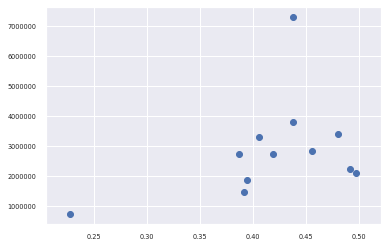

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.886
Model:                            OLS   Adj. R-squared (uncentered):              0.805
Method:                 Least Squares   F-statistic:                              10.90
Date:                Wed, 30 Oct 2019   Prob (F-statistic):                     0.00336
Time:                        10:58:07   Log-Likelihood:                         -184.02
No. Observations:                  12   AIC:                                      378.0
Df Residuals:                       7   BIC:                                      380.5
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
TBR1-LowDN cytoarchitecture fraction   8.716e+06   1.52e+07      0.572      0.585   -2.73e+07    4.47e+07
TBR1-HighDN cytoarchitecture fraction  1.993e+07   1.45e+07      1.378      0.211   -1.43e+07    5.41e+07
Surface cytoarchitecture fraction     -4.295e+04   8.17e+06     -0.005      0.996   -1.94e+07    1.93e+07
DN cytoarchitecture fraction          -1.711e+07   8.29e+06     -2.063      0.078   -3.67e+07     2.5e+06
Adjacent cytoarchitecture fraction      4.97e+06   4.55e+06      1.091      0.311    -5.8e+06    1.57e+07
==============================================================================
Omnibus:                        2.151   Durbin-Watson:                   2.347
Prob(Omnibus):                  0.341   Jarque-Bera (JB):                1.321
Skew:                           0.786   Prob(JB):                        0.517
Kurtosis:                       2.589   Cond. No.                         21.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

ventricle count


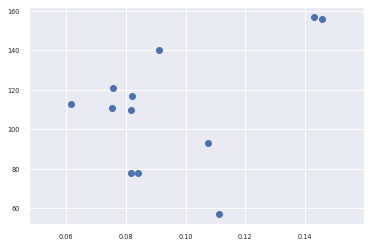

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.994
Model:                            OLS   Adj. R-squared (uncentered):              0.989
Method:                 Least Squares   F-statistic:                              219.4
Date:                Wed, 30 Oct 2019   Prob (F-statistic):                    1.56e-07
Time:                        10:58:07   Log-Likelihood:                         -43.582
No. Observations:                  12   AIC:                                      97.16
Df Residuals:                       7   BIC:                                      99.59
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
TBR1-LowDN cytoarchitecture fraction    709.8201    125.923      5.637      0.001     412.060    1007.580
TBR1-HighDN cytoarchitecture fraction   -34.9170    119.588     -0.292      0.779    -317.698     247.864
Surface cytoarchitecture fraction      -318.4396     67.523     -4.716      0.002    -478.107    -158.772
DN cytoarchitecture fraction             21.5426     68.549      0.314      0.762    -140.550     183.635
Adjacent cytoarchitecture fraction      311.5232     37.644      8.275      0.000     222.508     400.538
==============================================================================
Omnibus:                        2.394   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.302   Jarque-Bera (JB):                1.245
Skew:                          -0.784   Prob(JB):                        0.537
Kurtosis:                       2.823   Cond. No.                         21.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [386]:
keep = [
    'TBR1-LowDN cytoarchitecture fraction',
    'TBR1-HighDN cytoarchitecture fraction',
    'Surface cytoarchitecture fraction',
    'DN cytoarchitecture fraction',
    'Adjacent cytoarchitecture fraction',
]

df_filt = df_imputed.loc[keep]
X = df_filt.drop(columns='scales').T

print('organoid volume')
y = df_imputed.loc['organoid volume (mm3)'].drop('scales').astype(np.float64)[:, np.newaxis]

plt.figure()
plt.scatter(X.values[:, 3], y.ravel())
plt.show()

model = sm.OLS(y, X).fit()
display(model.summary())

print('ventricle volume')
y = df_imputed.loc['ventricle volume mean (um3)'].drop('scales').astype(np.float64)[:, np.newaxis]

plt.figure()
plt.scatter(X.values[:, 4], y.ravel())
plt.show()

model = sm.OLS(y, X).fit()
display(model.summary())

print('ventricle count')
y = df_imputed.loc['ventricle count'].drop('scales').astype(np.float64)[:, np.newaxis]

plt.figure()
plt.scatter(X.values[:, 0], y.ravel())
plt.show()

model = sm.OLS(y, X).fit()
display(model.summary())

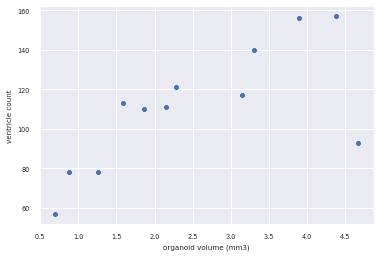

In [397]:
sns.scatterplot(x='organoid volume (mm3)', y='ventricle count', data=df.T)

## Difference in means vs linear regression

- d35->d60 hits go up or down
- Does the covariance of pairs of these hits within the d35 replicates resemble the covariance of pairs between d35 and d60

*Skip this analysis because it can be attacked by reviewers*